# SIIM-ISIC Melanoma Classification

### Introduction

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

This competition provides both image data (in DIOCOM, JPEG and TFRecord formats) and tabular data about each sample.

In this notebook, we are going to build two models that utilize both image and tabular data e ensemble the results. This is a starter code and if you have any suggestions or questions, please let me know in the comments.

#### Evaluation Metrics 

The metric in evaluation for this competition is AUC, that for [Area Under the ROC Curve](http://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

## Data Exploration

#### Loading packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import pydicom as dcm

import warnings
warnings.filterwarnings('ignore')


plt.style.use('ggplot')

#### Loading the tabular data

In [2]:
PATH = "/kaggle/input/siim-isic-melanoma-classification/"

train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [3]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission_df.shape}")

Train shape: (33126, 8)
Test shape: (10982, 5)
Sample submission shape: (10982, 2)


In [4]:
# Change columns names
new_names = ['image_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

In [5]:
train_df.head()

,image_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test_df.head()

,image_name,ID,sex,age,anatomy
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


#### Missing data

Text(0.5, 1.0, 'Test Missing Values Map')

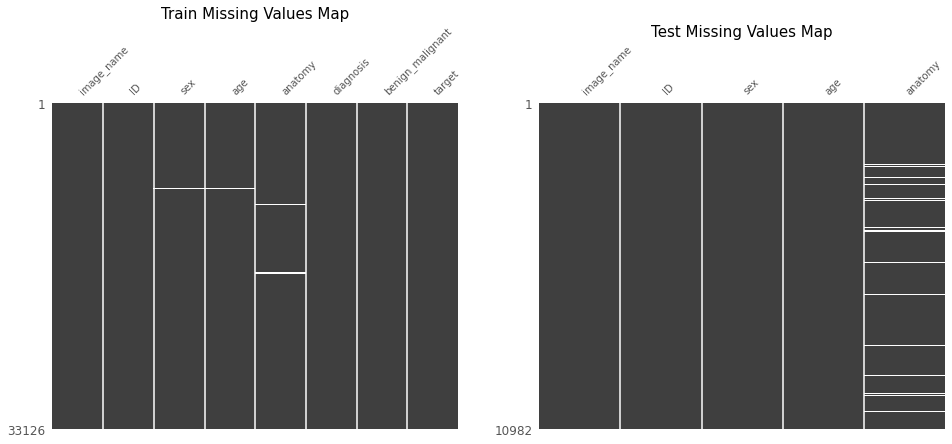

In [7]:
# Visualizing the missing values
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax=ax1, fontsize=10)
msno.matrix(test_df, ax=ax2, fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize=15)
ax2.set_title('Test Missing Values Map', fontsize=15)

In [8]:
print(train_df.shape)
train_df.isnull().sum()

(33126, 8)


image_name            0
ID                    0
sex                  65
age                  68
anatomy             527
diagnosis             0
benign_malignant      0
target                0
dtype: int64

In [9]:
print(test_df.shape)
test_df.isnull().sum()

(10982, 5)


image_name      0
ID              0
sex             0
age             0
anatomy       351
dtype: int64

#### Patients Distribution

In [10]:
# Unique IDs
print(f"The total patient IDs are {train_df.ID.count()}, from those the unique IDs are {train_df.ID.value_counts().shape[0]}.")

The total patient IDs are 33126, from those the unique IDs are 2056.


Text(0.5, 1.0, 'Images by Patient Distribution - Test')

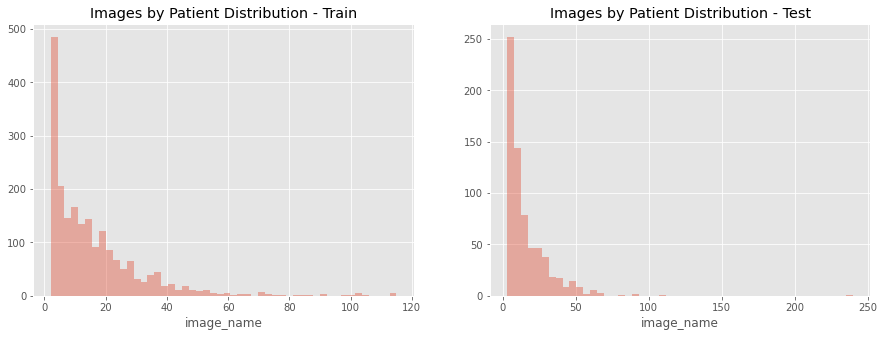

In [11]:
# Number of images by ID
patients_train = train_df.groupby('ID')['image_name'].count().reset_index()
patients_test = test_df.groupby('ID')['image_name'].count().reset_index()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(patients_train.image_name, kde=False, bins=50, ax=ax1)
sns.distplot(patients_test.image_name, kde=False, bins=50, ax=ax2)

ax1.set_title('Images by Patient Distribution - Train')
ax2.set_title('Images by Patient Distribution - Test')

'Sex' Variable

Text(0.5, 1.0, 'Gender Distribuition')

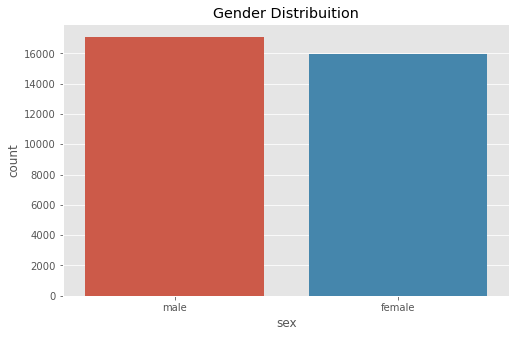

In [12]:
# Diagnosis and target
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='sex')
plt.title('Gender Distribuition')

Filling sex with the mode.

In [13]:
sex_mode = train_df.sex.mode()[0]
train_df.sex.fillna(sex_mode, inplace=True)
print('Mode:', sex_mode)

Mode: male


#### 'Age' Feature

Text(0.5, 1.0, 'Age Distribuition')

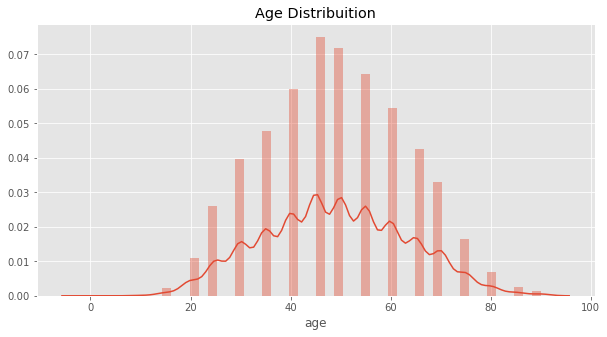

In [14]:
# Age Variable
plt.figure(figsize=(10, 5))
sns.distplot(train_df.age)
plt.title('Age Distribuition')

In [15]:
train_df.age.describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age, dtype: float64

In [16]:
# Filling the age variable with the median: 50 years.
age_median = train_df.age.median()
train_df.age.fillna(age_median, inplace=True)
print('Median:', age_median)

Median: 50.0


Text(0.5, 1.0, 'Age Distribution by Gender')

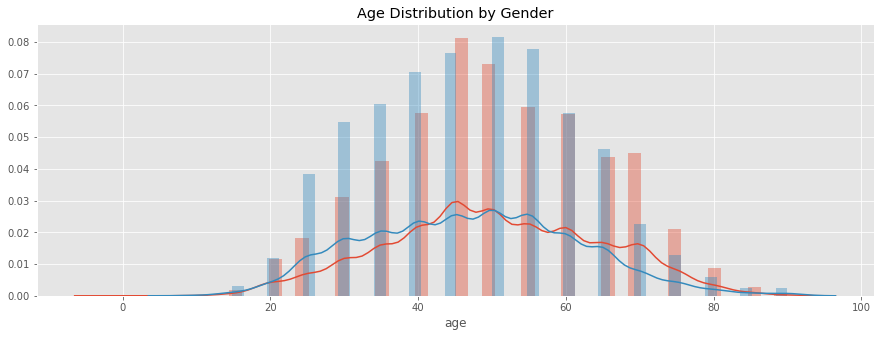

In [17]:
# Age distribution and sex
plt.figure(figsize=(15, 5))
sns.distplot(train_df[train_df.sex == 'male']['age'])
sns.distplot(train_df[train_df.sex == 'female']['age'])
plt.title('Age Distribution by Gender')

#### 'Anatomy' Feature

Text(0.5, 1.0, 'Scanned Body Parts')

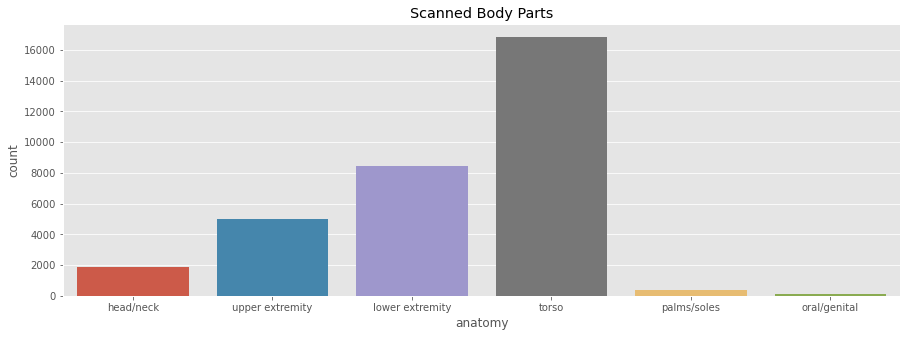

In [18]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='anatomy')
plt.title('Scanned Body Parts')

In [19]:
train_df.anatomy.value_counts(dropna=False)

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
NaN                  527
palms/soles          375
oral/genital         124
Name: anatomy, dtype: int64

In [20]:
# Checking the 'benign_malignant' variable of NaN values in 'anatomy'
train_df[train_df.anatomy.isnull()]['benign_malignant'].value_counts()

benign       518
malignant      9
Name: benign_malignant, dtype: int64

Since the most frequent 'benign_malignant' is benign in torso, we can set the NaN Values in 'anatomy' as torso.

In [21]:
train_df.anatomy.fillna('torso', inplace=True)

In [22]:
# Checking the test data
test_df.isnull().sum()

image_name      0
ID              0
sex             0
age             0
anatomy       351
dtype: int64

In [23]:
# Age variable of NaN values in 'anatomy' variable 
test_df[test_df.anatomy.isnull()]['age'].value_counts()

70.0    261
45.0     25
30.0     14
55.0     10
40.0     10
50.0      9
35.0      6
60.0      5
65.0      4
25.0      3
75.0      3
80.0      1
Name: age, dtype: int64

The majority of the people with missing anatomy have 70 yo, so we'll use the anatomy with the biggest frequency for age 70.

In [24]:
age_nan = test_df[test_df['age'] == 70]['anatomy'].value_counts().reset_index()['index'][0]
test_df.anatomy.fillna(age_nan, inplace=True)

Text(0.5, 1.0, 'Anatomy Distribution by Genders')

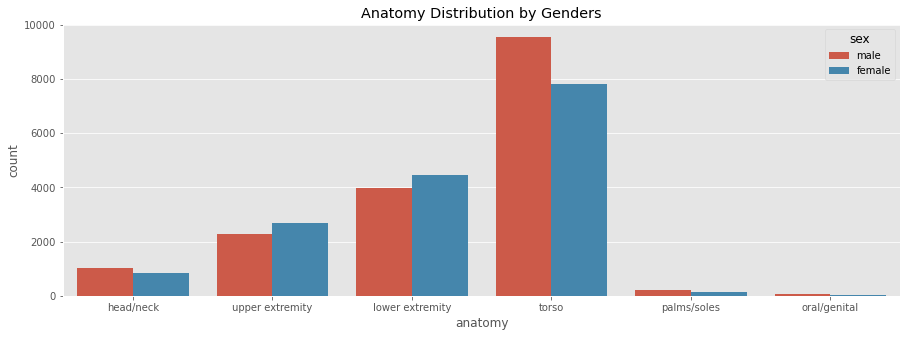

In [25]:
# Genders by Anatomy
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='anatomy', hue='sex')
plt.title('Anatomy Distribution by Genders')

#### 'Diagnosis'Feature


Text(0.5, 1.0, 'Diagnosis Distribuiton')

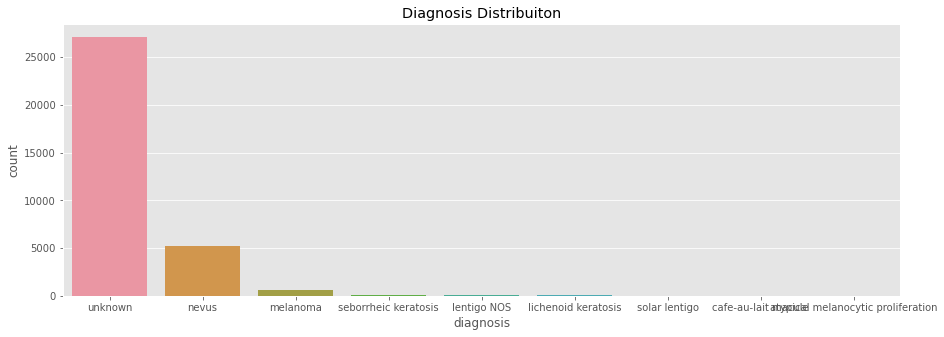

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='diagnosis')
plt.title('Diagnosis Distribuiton')

Text(0.5, 1.0, 'Diagnosis Distribution by Target')

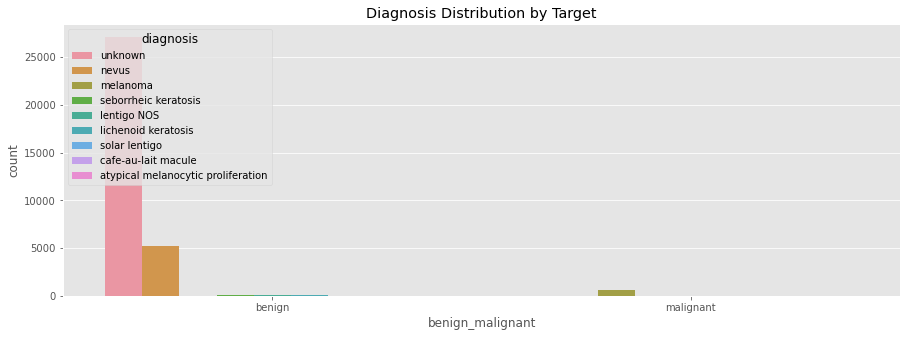

In [27]:
# Diagnosis and target
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='benign_malignant', hue='diagnosis')
plt.title('Diagnosis Distribution by Target')

Text(0.5, 1.0, 'Diagnosis Distribution by Genders')

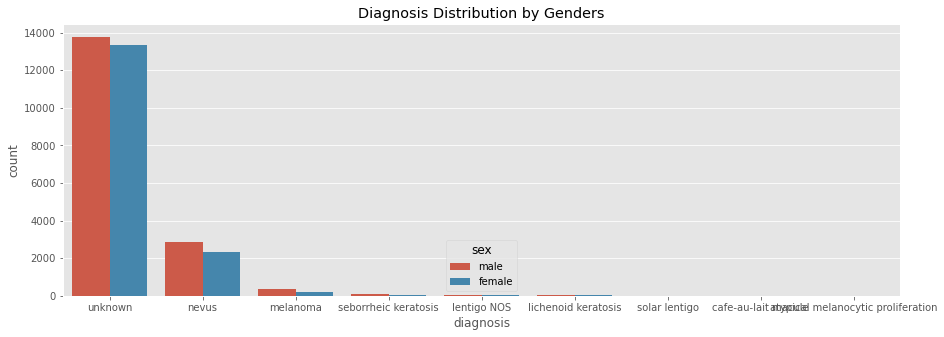

In [28]:
# Diagnosis and sex
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='diagnosis', hue='sex')
plt.title('Diagnosis Distribution by Genders')

#### Target

In [29]:
# Target
train_df.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distribuition')

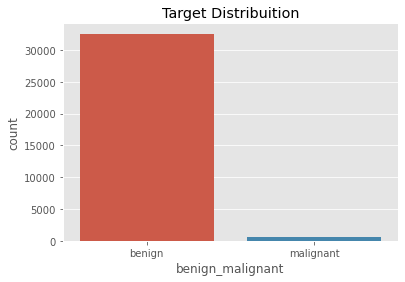

In [30]:
sns.countplot(data=train_df, x='benign_malignant')
plt.title('Target Distribuition')

Text(0.5, 1.0, 'Genders Distribuition by Target')

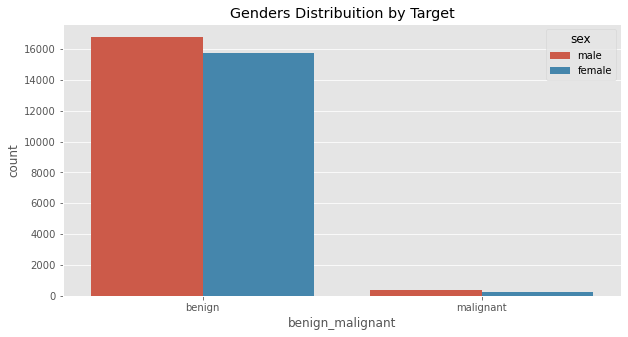

In [31]:
# Genders by target
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='benign_malignant', hue='sex')
plt.title('Genders Distribuition by Target')

Text(0.5, 1.0, 'Anatomy Distribuition by Target')

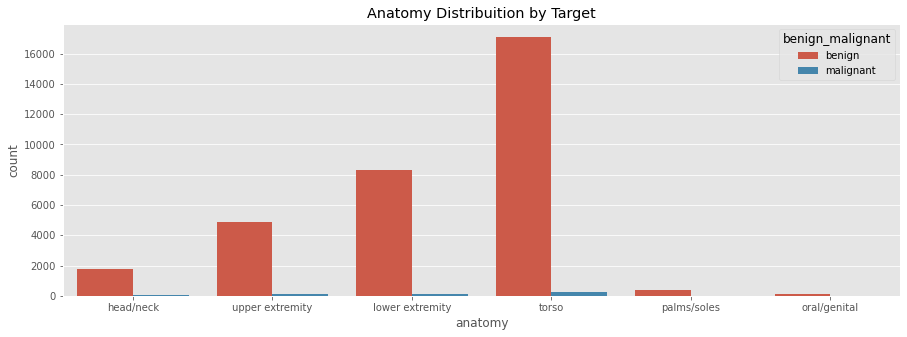

In [32]:
# Anatomy by target
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='anatomy', hue='benign_malignant')
plt.title('Anatomy Distribuition by Target')

### Image Data

First, we are going to show the DICOM images.

#### DICOM Images

In [33]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['image_name']+'.dcm'
        imagePath = os.path.join(PATH,"train/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.gray) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f"ID: {data_row['image_name']}\nAge: {age} Sex: {sex}\nDiagnosis: {data_row['diagnosis']}")
    plt.show()

Selecting images with target=0 (benign).

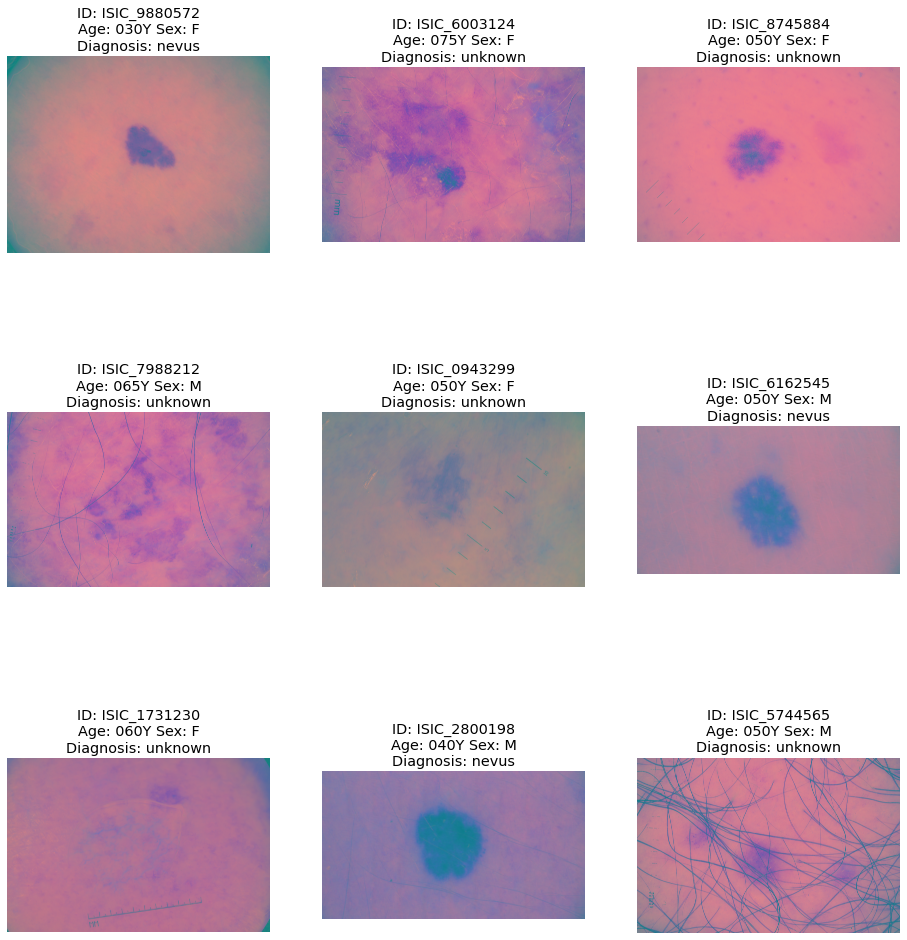

In [34]:
show_dicom_images(train_df[train_df.target == 0].sample(9))

Selecting images with target=1 (malignant).

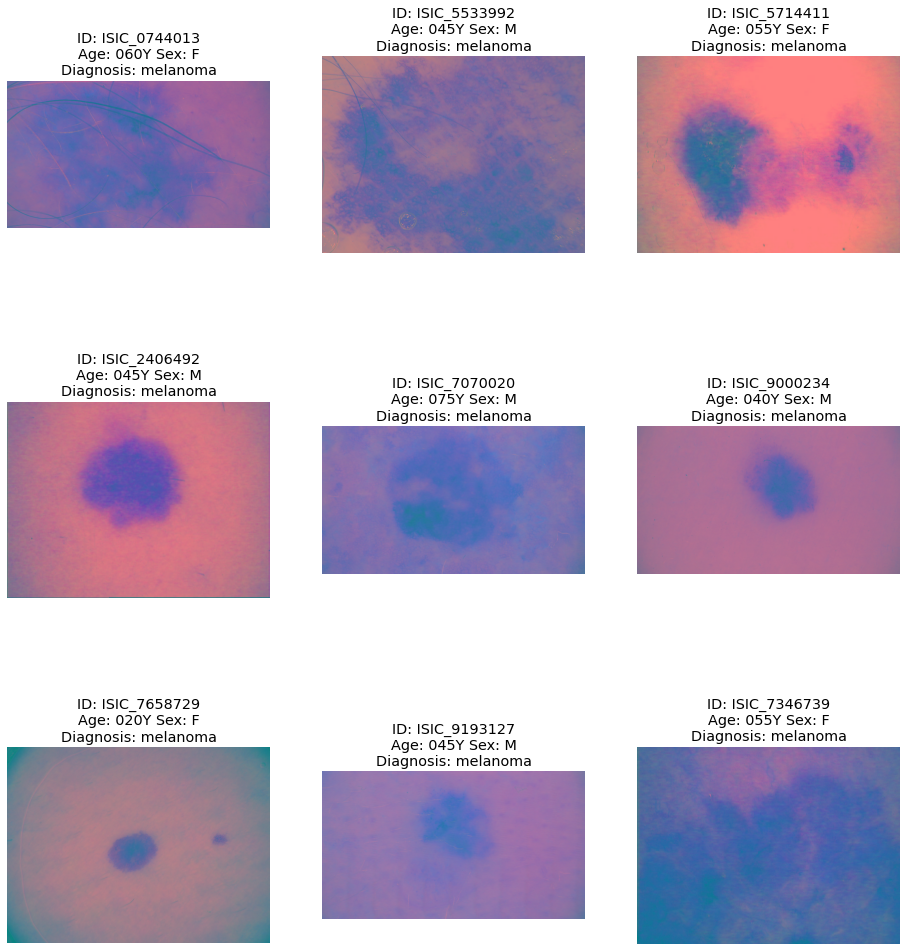

In [35]:
show_dicom_images(train_df[train_df.target == 1].sample(9))

Extracting data from DICOM images

In [36]:
def extract_DICOM_attributes(folder):
    images = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    for image in images:
        image_name = image.split(".")[0]
        dicom_file_path = os.path.join(PATH,folder,image)
        dicom_file_dataset = dcm.read_file(dicom_file_path)
        study_date = dicom_file_dataset.StudyDate
        modality = dicom_file_dataset.Modality
        age = dicom_file_dataset.PatientAge
        sex = dicom_file_dataset.PatientSex
        body_part_examined = dicom_file_dataset.BodyPartExamined
        patient_orientation = dicom_file_dataset.PatientOrientation
        photometric_interpretation = dicom_file_dataset.PhotometricInterpretation
        rows = dicom_file_dataset.Rows
        columns = dicom_file_dataset.Columns

        df = df.append(pd.DataFrame({'image_name': image_name, 
                        'dcm_modality': modality,'dcm_study_date':study_date, 'dcm_age': age, 'dcm_sex': sex,
                        'dcm_body_part_examined': body_part_examined,'dcm_patient_orientation': patient_orientation,
                        'dcm_photometric_interpretation': photometric_interpretation,
                        'dcm_rows': rows, 'dcm_columns': columns}, index=[0]))
    return df

In [37]:
df_train = extract_DICOM_attributes('train')
train_dicom_df = train_df.merge(df_train, on='image_name')

In [38]:
train_dicom_df.head()

,image_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,dcm_modality,dcm_study_date,dcm_age,dcm_sex,dcm_body_part_examined,dcm_patient_orientation,dcm_photometric_interpretation,dcm_rows,dcm_columns
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,"""XC""",20200519,045Y,M,HEAD/NECK,,YBR_FULL_422,4000,6000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,"""XC""",20200519,040Y,F,UPPER EXTREMITY,,YBR_FULL_422,4000,6000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,"""XC""",20200519,050Y,F,LOWER EXTREMITY,,YBR_FULL_422,1053,1872
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,"""XC""",20200519,045Y,F,HEAD/NECK,,YBR_FULL_422,1053,1872
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,"""XC""",20200519,055Y,F,UPPER EXTREMITY,,YBR_FULL_422,4000,6000


In [39]:
train_dicom_df.to_csv('train_dicom_df.csv', header=True, index=False) # todo

In [40]:
# todo

#### JPEG Images

Getting the images attributes. 
The code bellow its commented and imported it as a data becasue it's time consuming process.

In [41]:
#train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
#test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

In [42]:
#from tqdm import tqdm
#from tqdm.keras import TqdmCallback
#from keras.preprocessing import image
#
#for data, location in zip([train_df, test_df],[train_img_path, test_img_path]):
#    images = data['image_name'].values
#    reds = np.zeros(images.shape[0])
#    greens = np.zeros(images.shape[0])
#    blues = np.zeros(images.shape[0])
#    mean = np.zeros(images.shape[0])
#    x = np.zeros(images.shape[0], dtype=int)
#    y = np.zeros(images.shape[0], dtype=int)
#    for i, path in enumerate(tqdm(images)):
#        img = np.array(image.load_img(os.path.join(location, f'{path}.jpg')))
#
#        reds[i] = np.mean(img[:,:,0].ravel())
#        greens[i] = np.mean(img[:,:,1].ravel())
#        blues[i] = np.mean(img[:,:,2].ravel())
#        mean[i] = np.mean(img)
#        x[i] = img.shape[1]
#        y[i] = img.shape[0]
#
#    data['reds'] = reds
#    data['greens'] = greens
#    data['blues'] = blues
#    data['mean_colors'] = mean
#    data['width'] = x
#    data['height'] = y
#
#train_df['total_pixels']= train_df['width']*train_df['height']
#test_df['total_pixels']= test_df['width']*test_df['height']
#train_df['res'] = train_df['width'].astype(str) + 'x' + train_df['height'].astype(str)
#test_df['res'] = test_df['width'].astype(str) + 'x' + test_df['height'].astype(str)

In [43]:
#train_df.head()

In [44]:
# Save the files
#train_df.to_csv('train_atr.csv', index=False)
#test_df.to_csv('test_atr.csv', index=False)

In [45]:
PATH_IMAGES = "/kaggle/input/imagesatr"

train_df = pd.read_csv(os.path.join(PATH_IMAGES, 'train_atr.csv'))
test_df = pd.read_csv(os.path.join(PATH_IMAGES, 'test_atr.csv'))

In [46]:
# todo

### Building Our Models

#### Modelling Based on Tabular data - XGBoost

In [47]:
# Loading sample submission data
PATH = "/kaggle/input/siim-isic-melanoma-classification/"

sample_submission_df = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

One Hot Encoding for categorical features: sex and anatomy.

In [48]:
# Getting dummy variables for gender on train set
sex_dummies = pd.get_dummies(train_df.sex, prefix='sex')
train_df = pd.concat([train_df, sex_dummies], axis=1)

# Now, on test set
sex_dummies = pd.get_dummies(test_df.sex, prefix='sex')
test_df = pd.concat([test_df, sex_dummies], axis=1)

In [49]:
train_df.head()

,image_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,reds,greens,blues,mean_colors,width,height,total_pixels,res,sex_female,sex_male
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,212.935898,138.914175,157.742255,169.864109,6000,4000,24000000,6000x4000,0,1
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,217.292550,165.093667,130.881285,171.089167,6000,4000,24000000,6000x4000,1,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,199.941121,130.227057,145.908743,158.692307,1872,1053,1971216,1872x1053,1,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,119.690968,62.614725,58.724976,80.343556,1872,1053,1971216,1872x1053,1,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,226.279244,173.174914,152.425131,183.959763,6000,4000,24000000,6000x4000,1,0


In [50]:
# Getting dummy variables for anatomy on train set
anatomy_dummies = pd.get_dummies(train_df.anatomy, prefix='anatomy')
train_df = pd.concat([train_df, anatomy_dummies], axis=1)

# Now, on test set
anatomy_dummies = pd.get_dummies(test_df.anatomy, prefix='anatomy')
test_df = pd.concat([test_df, anatomy_dummies], axis=1)

In [51]:
train_df.columns

Index(['image_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis',
       'benign_malignant', 'target', 'reds', 'greens', 'blues', 'mean_colors',
       'width', 'height', 'total_pixels', 'res', 'sex_female', 'sex_male',
       'anatomy_head/neck', 'anatomy_lower extremity', 'anatomy_oral/genital',
       'anatomy_palms/soles', 'anatomy_torso', 'anatomy_upper extremity'],
      dtype='object')

In [52]:
# Removing white space 
train_df.columns = train_df.columns.str.replace(' ', '_')
train_df.columns = train_df.columns.str.replace('/', '_')

test_df.columns = test_df.columns.str.replace(' ', '_')
test_df.columns = test_df.columns.str.replace('/', '_')

# Dropping not usefull columns
train_df.drop(['image_name', 'ID','sex', 'anatomy', 'diagnosis', 'benign_malignant', 'res'], axis=1, inplace=True)
test_df.drop(['image_name', 'ID','sex', 'anatomy', 'res'], axis=1, inplace=True)

In [53]:
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score

X = train_df.drop(['target'], axis=1)
y = train_df.target

In [54]:
# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model on all training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

validation = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, validation)

0.8343154689261596

ROC_AUC score: 0.834315

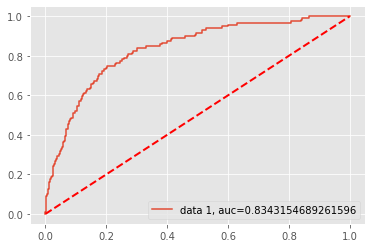

In [55]:
from sklearn import metrics
# plotando a curva ROC
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

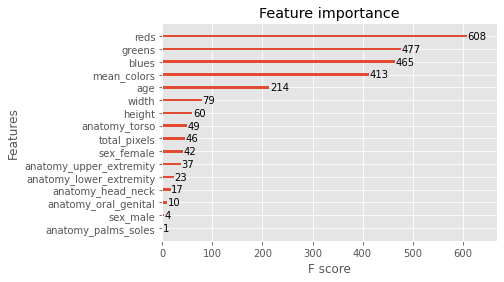

In [56]:
from xgboost import plot_importance
model = xgb.XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

Prediction 1 - XGBoost for the sample submission based on tabular data.

In [57]:
# Prediction 1
predictions = model.predict_proba(test_df)
metadata_df = pd.DataFrame(columns=['image_name', 'target'])

metadata_df['image_name'] = sample_submission_df['image_name']
metadata_df['target'] = predictions

In [58]:
# Making the prediction
model.fit(X_train, y_train)
predictions = model.predict_proba(test_df)[:, 1]

metadata_df = pd.DataFrame(columns=['image_name', 'target'])
metadata_df['image_name'] = sample_submission_df['image_name']
metadata_df['target'] = predictions

In [59]:
metadata_df.head()

,image_name,target
0,ISIC_0052060,0.000441
1,ISIC_0052349,0.000026
2,ISIC_0058510,0.000048
3,ISIC_0073313,0.001051
4,ISIC_0073502,0.001954


In [60]:
# creating submission csv file
metadata_df.to_csv('submission_tabular.csv', header=True, index=False)

#### Modelling Based on Image Data - EfficientNetB3

Using neural networks for prediction based on image data.

In [61]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [62]:
import os
import re

import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L

import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

In [63]:
# Setting TPU as main device for training
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [64]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Configuration
DEBUG = False
N_FOLD = 4
EPOCHS = 1 if DEBUG else 7
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

In [65]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
test_files = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

In [66]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_test_dataset(test_files, ordered=False):
    dataset = load_dataset(test_files, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

Prediction 2 - Modelling image data

In [67]:
def get_model():
    
    with strategy.scope():
        model = tf.keras.Sequential([
            efn.EfficientNetB3(
                input_shape=(*IMAGE_SIZE, 3),
                weights=None,
                include_top=False
            ),
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
    
    return model

In [68]:
# Inference
from tqdm import tqdm

pred_df = pd.DataFrame()

tk0 = tqdm(range(N_FOLD), total=N_FOLD)

for fold in tk0:
    num_test = count_data_items(test_files)
    test_ds = get_test_dataset(test_files, ordered=True)
    test_images_ds = test_ds.map(lambda image, idnum: image)
    model = get_model()
    probabilities = model.predict(test_images_ds)
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(num_test))).numpy().astype('U')
    _pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
    pred_df = pd.concat([pred_df, _pred_df])

100%|██████████| 4/4 [06:11<00:00, 92.95s/it]


In [69]:
mean_pred_df = pred_df.groupby('image_name', as_index=False).mean()
mean_pred_df.columns = ['image_name', 'target']

In [70]:
mean_pred_df.head()

,image_name,target
0,ISIC_0052060,0.499979
1,ISIC_0052349,0.499976
2,ISIC_0058510,0.499974
3,ISIC_0073313,0.499975
4,ISIC_0073502,0.499979


In [71]:
pred_df.head()

,image_name,target
0,ISIC_6381819,0.499992
1,ISIC_5583376,0.499993
2,ISIC_6408546,0.499991
3,ISIC_6932354,0.499993
4,ISIC_8191278,0.499991


In [72]:
# creating submission csv file
mean_pred_df.to_csv('submission_image.csv', header=True, index=False)

### Ensemble

Final step. We'll use our blended predictions created by training images and simply metadata created by using tabular data. We ensemble them together with weights and make our final predictions. 

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
image_sub = pd.read_csv('/kaggle/working/submission_image.csv')
tabular_sub = pd.read_csv('/kaggle/working/submission_tabular.csv')
tabular_sub.head()

,image_name,target
0,ISIC_0052060,0.000441
1,ISIC_0052349,0.000026
2,ISIC_0058510,0.000048
3,ISIC_0073313,0.001051
4,ISIC_0073502,0.001954


In [75]:
submission = image_sub.copy()
submission.target = 0.9 * image_sub.target.values + 0.1 * tabular_sub.target.values
submission.to_csv('submission.csv',index=False)

This is not the final version. 

I would like to thank the community who helped me complete this challenge, especially to the competitors below:

**References**

https://www.kaggle.com/gpreda/siim-isic-melanoma-classification-eda

https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations

https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble/data

https://www.kaggle.com/parulpandey/melanoma-classification-eda-starter

https://www.kaggle.com/forwet/tensorflow-transfer-learning-melanoma

https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma

https://www.kaggle.com/cdeotte/image-and-tabular-data-0-915

https://www.kaggle.com/kittlein/xgboost-tabular-data-ml-cv-86-lb-787

https://www.kaggle.com/zainahmad/eda-melanoma-classification-using-tensorflow

https://www.kaggle.com/redwankarimsony/melanoma-eda-efficentnets-densenet-ensemble#4.-TPU-Setup-Code

https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords

https://www.kaggle.com/tunguz/melanoma-classification-eda-and-modeling

